# 周期分析

计算最有效的周期指标，捕捉中短期价格反转。

菲舍尔转换，带通滤波器，超级震荡指标。



In [ ]:
# // Calculate bandpass filter for input source
# // Source: input source series
# // Period: period of the filter
# // BandWidth: bandwidth of the filter
# var bandpass(vars Sources, int Period, var BandWidth) {
#     var Const = BandWidth * 2 * PI / Period;
#     var Beta = cos(2 * PI / Period);
#     var Gamma = 1.0 / cos(Const);
#     var Alpha1 = Gamma - sqrt((Gamma * Gamma) - 1);
#     var Alpha2 = (cos(0.25 * Const) + sin(0.25 * Const) - 1) / cos(0.25 * Const);
#     var Alpha3 = (cos(1.5 * Const) + sin(1.5 * Const) - 1) / cos(1.5 * Const);

#     // Apply the filter to the input signal.
#     vars HP = series(0.0, 3);
#     HP[0] = ((1 + (Alpha2 / 2)) * (Sources[0] - Sources[1])) + ((1 - Alpha2) * HP[1]);

#     vars BP = series(0.0, 3);
#     BP[0] = (0.5 * (1 - Alpha1) * (HP[0] - HP[2])) + (Beta * (1 + Alpha1) * BP[1]) - (Alpha1 * BP[2]);

#     // Normalize the output signal.
#     vars Peaks = series(0.0, 2);
#     Peaks[0] = 0.991 * Peaks[1];
#     if (abs(BP[0]) > Peaks[0])
#         Peaks[0] = abs(BP[0]);

#     var Signal = 0.0;
#     if (Peaks[0] != 0)
#         Signal = BP[0] / Peaks[0];

#     return Signal;
# }


# // Calculate fisher transform for input source
# // Source: input source series
# // Period: period of the filter
# var fisherTransform(vars Sources, int Period) {
#     // Calculate the highest and lowest values of the source series
#     var Highest = MaxVal(Sources, Period);
#     var Lowest = MinVal(Sources, Period);

#     // Calculate the value of the Fisher Transform
#     vars Values = series(0., 2);
#     vars Fishers = series(0., 2);
#     Values[0] = 0.66*((Sources[0]-Lowest)/(Highest-Lowest)-0.5) + 0.67*Values[1];
#     Values[0] = max(min(Values[0], 0.999), -0.999);
#     Fishers[0] = 0.5*log((1+Values[0])/(1-Values[0])) + 0.5*Fishers[1];

#     // Return the Fisher Transform of the source series
#     return Fishers[0];
# }


# // Stochastic CG(Center of Gravity) oscillator
# var stochCenterGravityOsc(vars Sources, int Period) {
#     // Calculate Center of Gravity
#     var nm = 0.0, dm = 0.0;
#     int i;
#     for(i=0; i<Period; i++) {
#         nm += (i+1)*Sources[i];
#         dm += Sources[i];
#     }
#     vars CenterGravitys = series(ifelse(dm > 0, -nm/dm+(Period+1)/2.0, 0));

#     // Apply stochastic formula to CG
#     var MaxCG = MaxVal(CenterGravitys, Period);
#     var MinCG = MinVal(CenterGravitys, Period);
#     var Stoch = ifelse(MaxCG == MinCG, 0, (CenterGravitys[0] - MinCG)/(MaxCG - MinCG));
#     vars Stochs = series(Stoch);

#     // Calculate a 4-period weighted moving average of v1
#     var SmoothStoch = (4*Stochs[0] + 3*Stochs[1] + 2*Stochs[2] + Stochs[3])/10.0;

#     // Scale oscillator to a range from -1 to 1
#     return 2*(SmoothStoch - 0.5);
# }



In [52]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [9]:
def read_binance_annual_ohlcv(year: int) -> pd.DataFrame:
    filepath = os.path.join("../data", f"binance_daily_ohlcv_{year}.csv")
    return pd.read_csv(filepath, index_col="timestamp", parse_dates=True)


years = [2022, 2023, 2024]
ohlcv = pd.concat((read_binance_annual_ohlcv(year) for year in years))

计算菲舍尔转换

In [36]:
ohlcv_btc = ohlcv.query("symbol == 'BTC/USDT'").copy()
ohlcv_btc

,open,high,low,close,volume,symbol
timestamp,,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,BTC/USDT
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,BTC/USDT
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,BTC/USDT
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360,BTC/USDT
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857,BTC/USDT
...,...,...,...,...,...,...
2024-04-05,68487.80,68756.67,65952.56,67820.62,37915.23073,BTC/USDT
2024-04-06,67820.63,69692.00,67447.83,68896.00,20134.28919,BTC/USDT
2024-04-07,68896.00,70326.29,68824.00,69360.39,21534.74433,BTC/USDT


In [41]:
def fisher_transform(series: pd.Series, period: int = 10) -> pd.Series:
    highest = series.rolling(period, min_periods=1).max()
    lowest = series.rolling(period, min_periods=1).min()
    values = np.zeros(len(series))
    fishers = np.zeros(len(series))
    
    for i in range(1, len(series)):
        values[i] = 0.66*((series.iloc[i]-lowest.iloc[i])/(highest.iloc[i]-lowest.iloc[i])-0.5) + 0.67*values[i-1]
        values[i] = max(min(values[i], 0.999), -0.999)
        fishers[i] = 0.5*np.log((1+values[i])/(1-values[i])) + 0.5*fishers[i-1]
    
    return pd.Series(fishers, index=series.index)

In [42]:
ohlcv_btc["ft"] = fisher_transform(ohlcv_btc["close"])
ohlcv_btc

,open,high,low,close,volume,symbol,ft
timestamp,,,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,BTC/USDT,0.000000
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,BTC/USDT,-0.342828
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,BTC/USDT,-0.791374
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360,BTC/USDT,-1.261493
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857,BTC/USDT,-1.725175
...,...,...,...,...,...,...,...
2024-04-05,68487.80,68756.67,65952.56,67820.62,37915.23073,BTC/USDT,-0.087481
2024-04-06,67820.63,69692.00,67447.83,68896.00,20134.28919,BTC/USDT,-0.071631
2024-04-07,68896.00,70326.29,68824.00,69360.39,21534.74433,BTC/USDT,0.057938


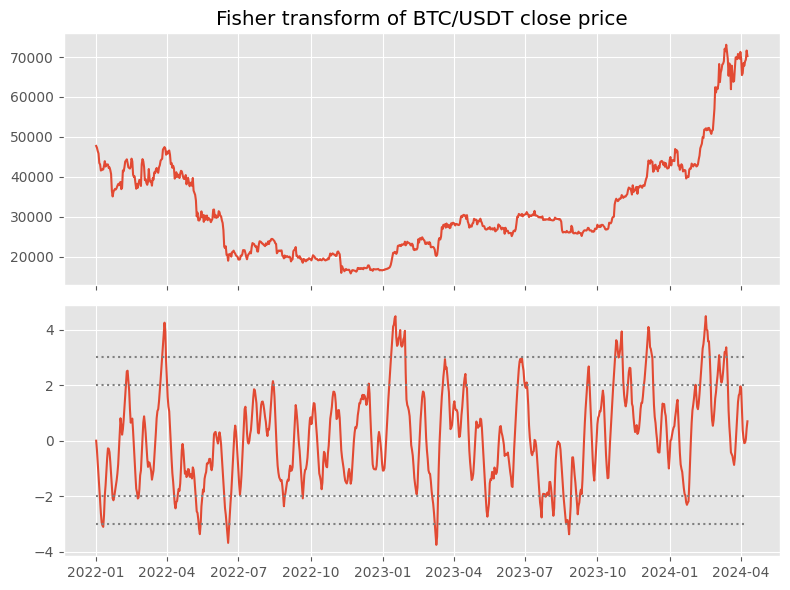

In [55]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax0.plot(ohlcv_btc["close"], label="Close Price")
ax1.plot(ohlcv_btc["ft"], label="Fisher Transform")
ax1.hlines(2, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
ax1.hlines(-2, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
ax1.hlines(3, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")
ax1.hlines(-3, ohlcv_btc.index[0], ohlcv_btc.index[-1], color="grey", linestyle="dotted")

ax0.set_title("Fisher transform of BTC/USDT close price")

plt.tight_layout()